Домашнее задание 1:

- Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

- Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;

- Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

- Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

- Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

- Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

- Задание 7 (опция): Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing

p.s. это обязательная программа для выполнения домашки, вы можете расширить эту программу и сделать больше; я только за :)

In [21]:
#!pip install missingno

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
train_path = 'C:/Users/Anatoly/Desktop/kaggle/HW1/train.csv'

In [3]:
test_path = 'C:/Users/Anatoly/Desktop/kaggle/HW1/test.csv'

In [4]:
df_train = pd.read_csv(train_path)

In [5]:
df_test = pd.read_csv(test_path)

In [6]:
df_train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [7]:
df_test.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7197  
1  -1.4852   9.8714  19.1293 -20.9760  
2  -7.1086   7.0618  19.8956 -23.1794  
3   3.9567   9.2295  13.0168  -4.2108  
4  -5.1612   7.2882  13.9260  -9.1846  

[5 rows x 201 columns]

## Задание 1: Сделать базовый анализ данных 

In [8]:
#Размерность датасетов

In [9]:
df_train.shape

(200000, 202)

In [10]:
df_test.shape

(200000, 201)

In [11]:
# В тестовом и тренировочном наборах 200 000 строк. 202 столбца - в трейне. 201 столбец - в тесте. 

Получение сводной статистики по всем значениям, за иключением пропусков, через метод describe():

In [12]:
df_train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [13]:
df_test.describe()

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean        0.277135       7.569407  ...       3.189766       7.458269   
std         3.333375       1.231865  ...       4.551239       3.025189   
min        -9.956000       4.243300  ...     -14.093300      -2.407000   
25%        -2.303900       6.623800  ...      -0.095000       5.166500   
50%         0.372000       7.632000  ...       3.162400       7.379000   
75%         2.930025       8.584825  ...       6.336475       9.531100   
max         9.665500      11.003600  ...      20.359000      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.925944       3.322016      17.996967      -0.133657   
std         1.479966       3.995599       3.140652       1.429678   
min        -3.340900     -11.413100       9.382800      -4.911900   
25%         0.882975       0.587600      15.634775      -1.160700   
50%         1.892600       3.428500      17.977600      -0.162000   
75%         2.956000       6.174200      20.391725       0.837900   
max         8.005000      17.632600      27.947800       4.545400   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.290899       8.912428      15.869184      -3.246342  
std         5.446346       0.920904       3.008717      10.398589  
min       -13.944200       6.169600       6.584000     -39.457800  
25%        -1.948600       8.260075      13.847275     -11.124000  
50%         2.403600       8.892800      15.943400      -2.725950  
75%         6.519800       9.595900      18.045200       4.935400  
max        15.920700      12.275800      26.538400      27.907400  

[8 rows x 200 columns]

Анализ пропусков

<AxesSubplot:>

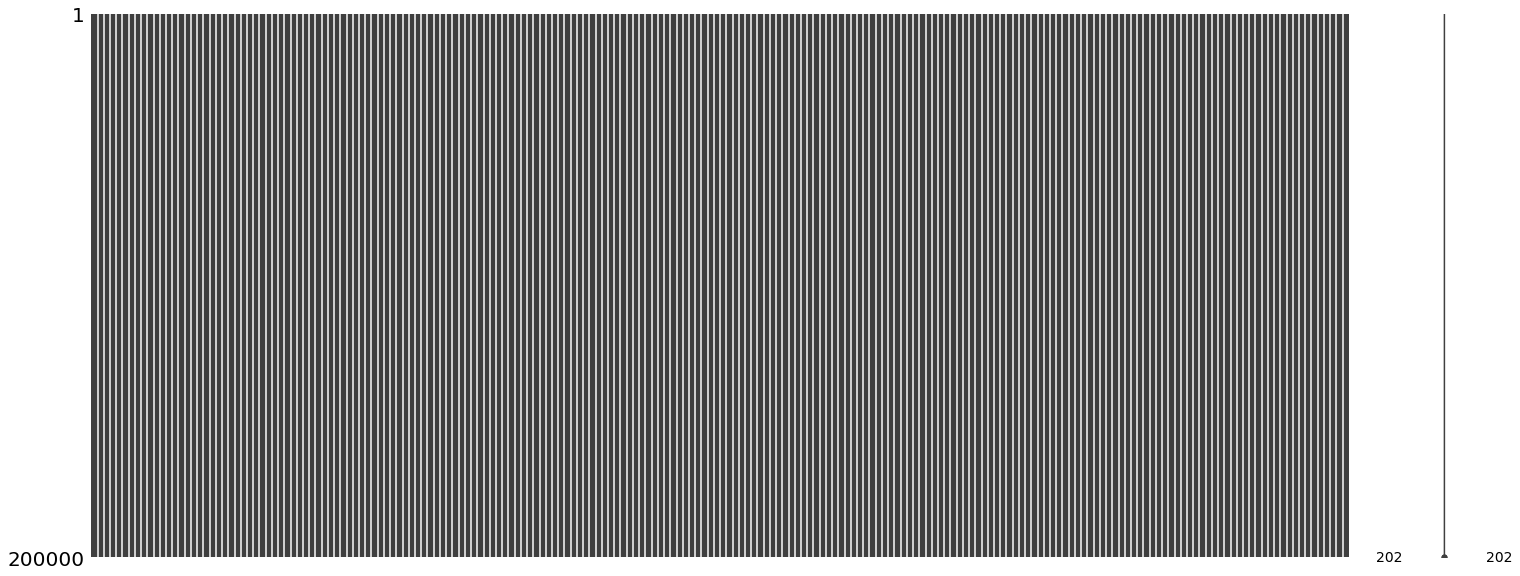

In [14]:
msno.matrix(df_train)

In [15]:
#Подозрительно. Неужели нет пропусков? Проверим еще раз на тесте и на трейне. 

In [16]:
features_with_na_train = [
    feature for feature in df_train.columns
    if df_train[feature].isnull().sum() > 1]

In [17]:
features_with_na_train

[]

In [18]:
#Проверка на тесте:

In [19]:
features_with_na_test = [
    feature for feature in df_test.columns
    if df_test[feature].isnull().sum() > 1]

In [20]:
features_with_na_test

[]

In [21]:
#Вывод: на трейне и на тесте пропусков нет. 

Выводы по заданию 1: пропусков в датасете нет, по базовой статистике видно, что целевая переменная target
несбалансирована (Mean = 0.1). Далее сделаем анализ целевой переменной. 

## Задание 2: Сделать базовый анализ целевой переменной

In [22]:
target = df_train['target']

In [23]:
df_train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

<AxesSubplot:>

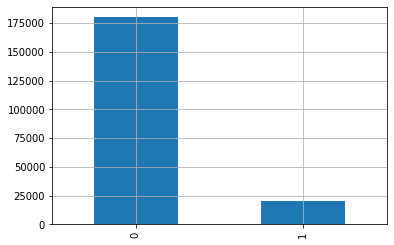

In [24]:
df_train.target.value_counts().plot(kind='bar', grid = True)

In [25]:
# Как и писал ранее - переменная несбалансирована. Дисбаланс классов примерно в 10 раз. 

In [26]:
# Поскольку наша целевая переменная не подчинена какому-либо из законов распределения, то скорее всего строить
# q-q plot или p-p plot некорректно. 

## Анализ признаков

In [27]:
numerical_features_train = df_train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_train.shape[1]}")

numerical_features_train.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [28]:
numerical_features_test = df_test.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_test.shape[1]}")

numerical_features_test.columns

count of numeric_features 200


Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [29]:
# Категориальный признак в датасете один - ID code. Все остальные признаки - числовые. 

In [30]:
df_train.ID_code.value_counts()

train_111088    1
train_39306     1
train_20347     1
train_147438    1
train_185255    1
               ..
train_162630    1
train_134297    1
train_123900    1
train_35538     1
train_112642    1
Name: ID_code, Length: 200000, dtype: int64

In [31]:
df_test.ID_code.value_counts()

test_125185    1
test_73638     1
test_60709     1
test_197473    1
test_177289    1
              ..
test_113113    1
test_120688    1
test_149112    1
test_106048    1
test_69624     1
Name: ID_code, Length: 200000, dtype: int64

In [32]:
#Пока нет ясности оставить или удалить столбец ID_code. Нужно понять, отражает ли ID_code временную зависимость.
#Если да, то оставляем и используем. 

## Дискретные признаки

In [35]:
discrete_feature_train = [
    feature for feature in numerical_features_train
    if len(df_train[feature].unique())<25
]

In [36]:
discrete_feature_test = [
    feature for feature in numerical_features_test
    if len(df_train[feature].unique())<25
]

In [37]:
discrete_feature_train

['target']

In [38]:
discrete_feature_test

[]

In [39]:
#дискретных признаков нет, только непреревные. 

In [42]:
continuous_feature_train = [
    feature for feature in numerical_features_train
    if feature not in discrete_feature_train]

print(f"Continuous Feature Count {len(continuous_feature_train)}")

Continuous Feature Count 200


In [43]:
continuous_feature_test = [
    feature for feature in numerical_features_test
    if feature not in discrete_feature_test]

print(f"Continuous Feature Count {len(continuous_feature_train)}")

Continuous Feature Count 200


In [44]:
#Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение
#признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков,
#то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40,
#var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196

In [82]:
# Вывести сразу все зависимости не получится, необходимо написать функцию и вызывать ее кратное число раз
# для отображения графиков.

In [80]:
def group_graf(group):
    fig, axes = plt.subplots(5, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        try:
            train_data, test_data = df_train[feature].copy(), df_test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        axes[num//4, num%4].set_title(feature, fontsize=14)

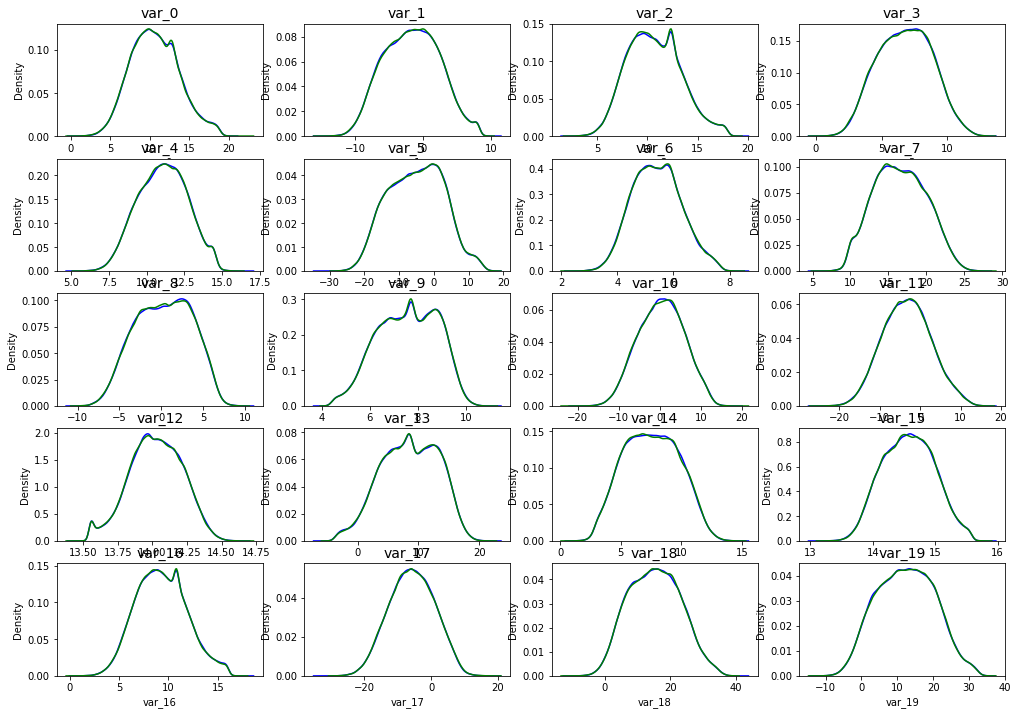

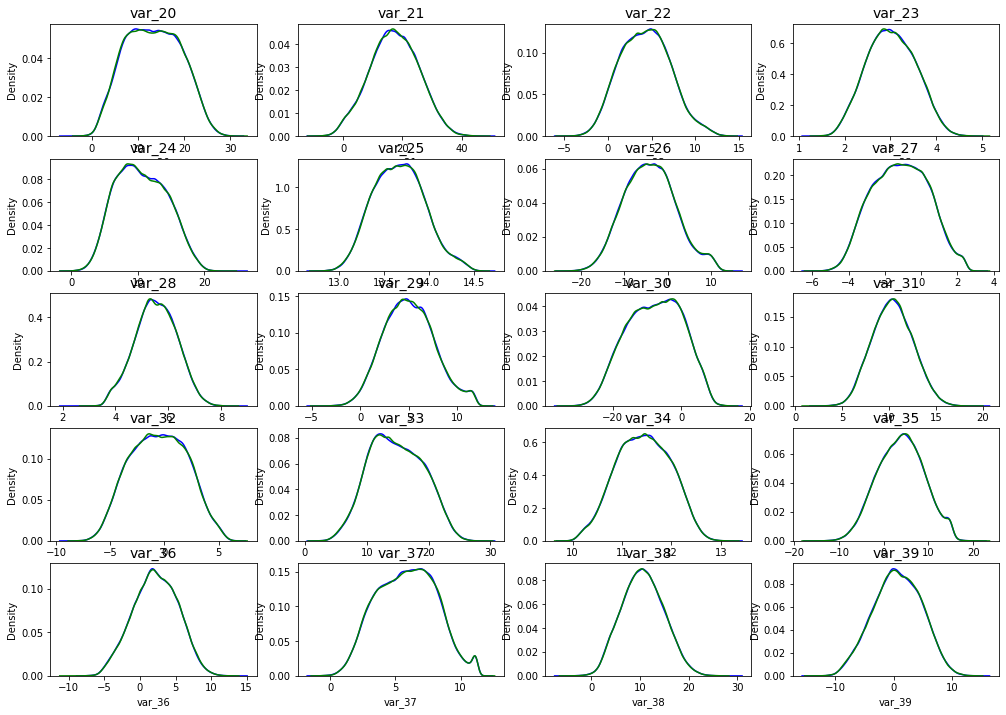

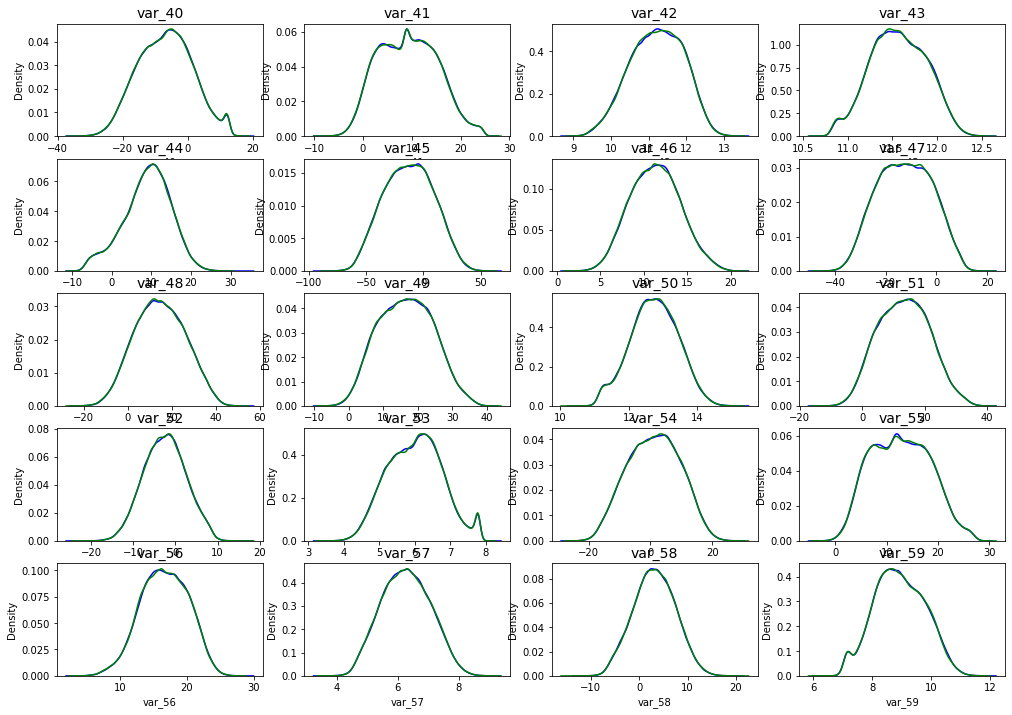

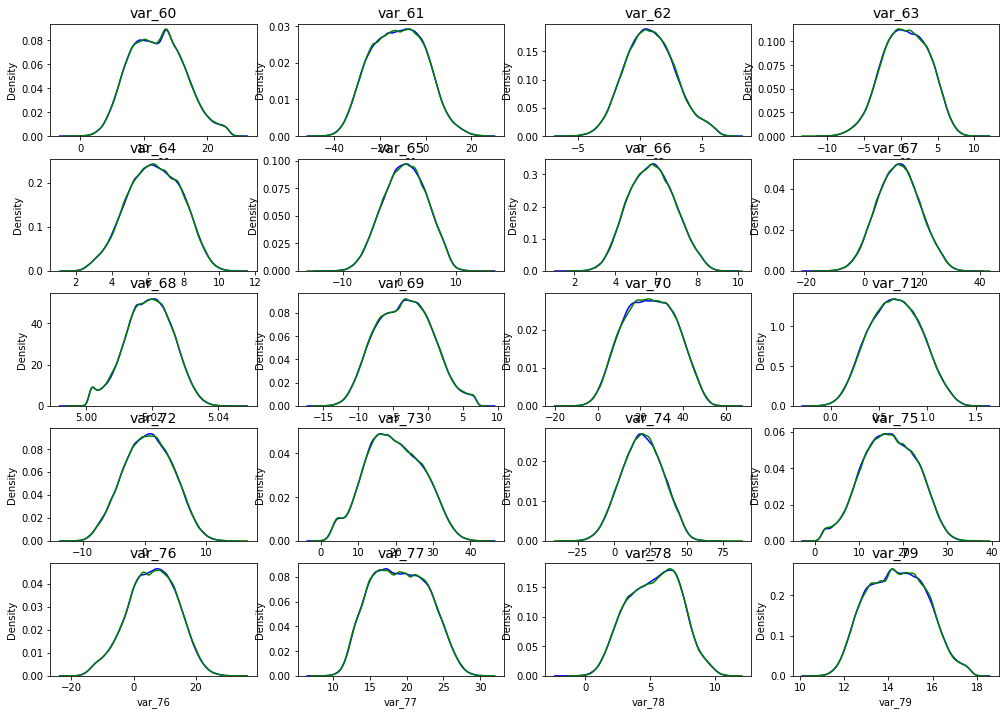

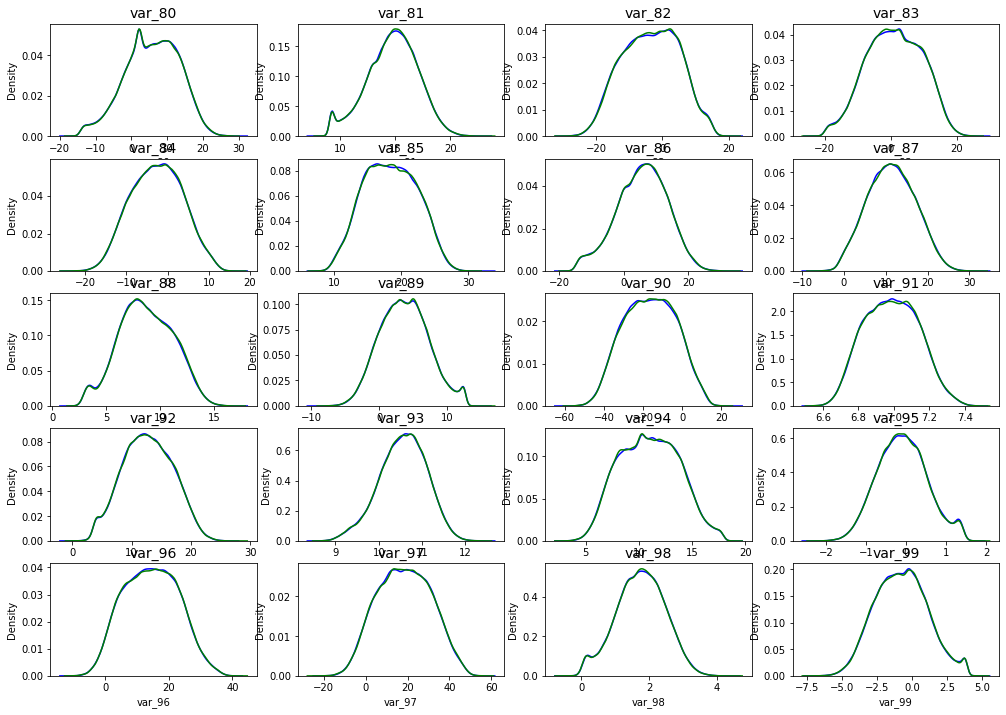

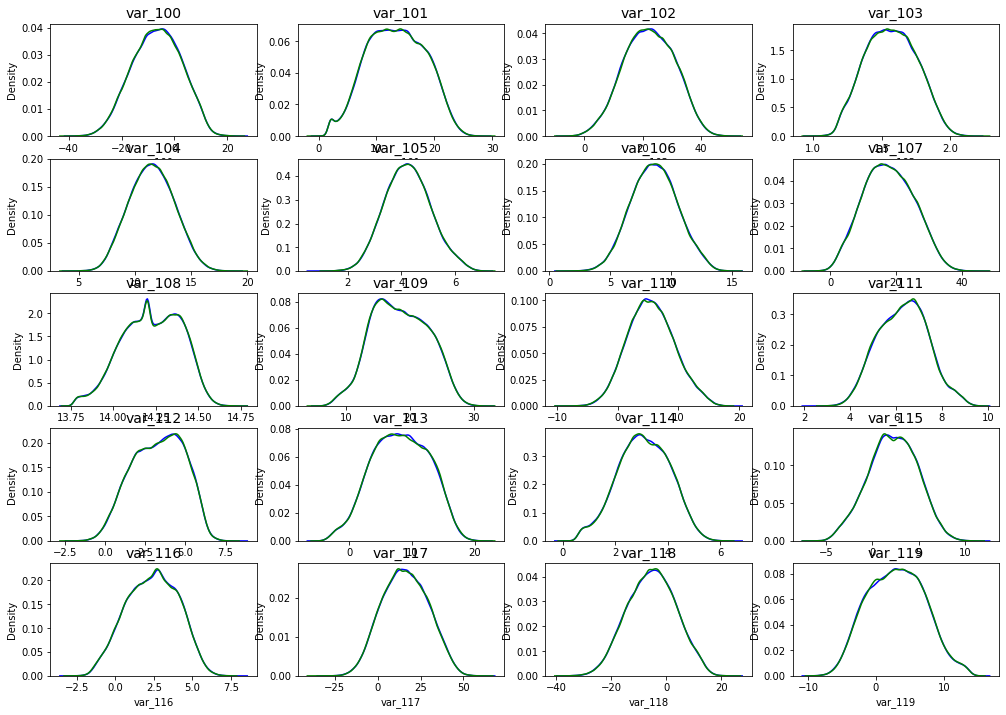

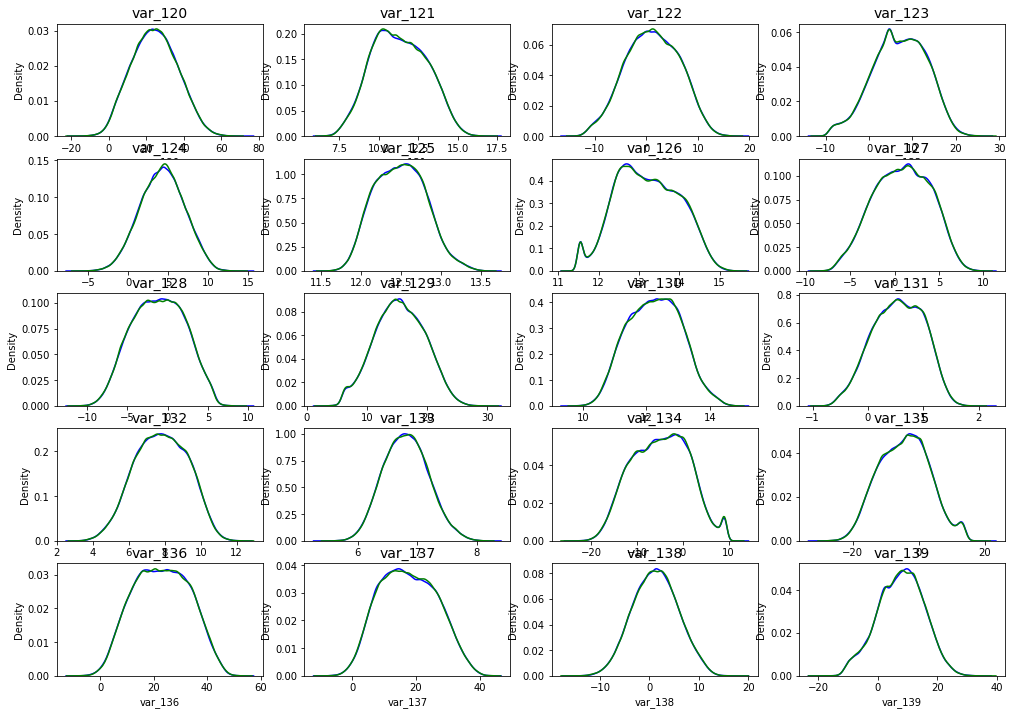

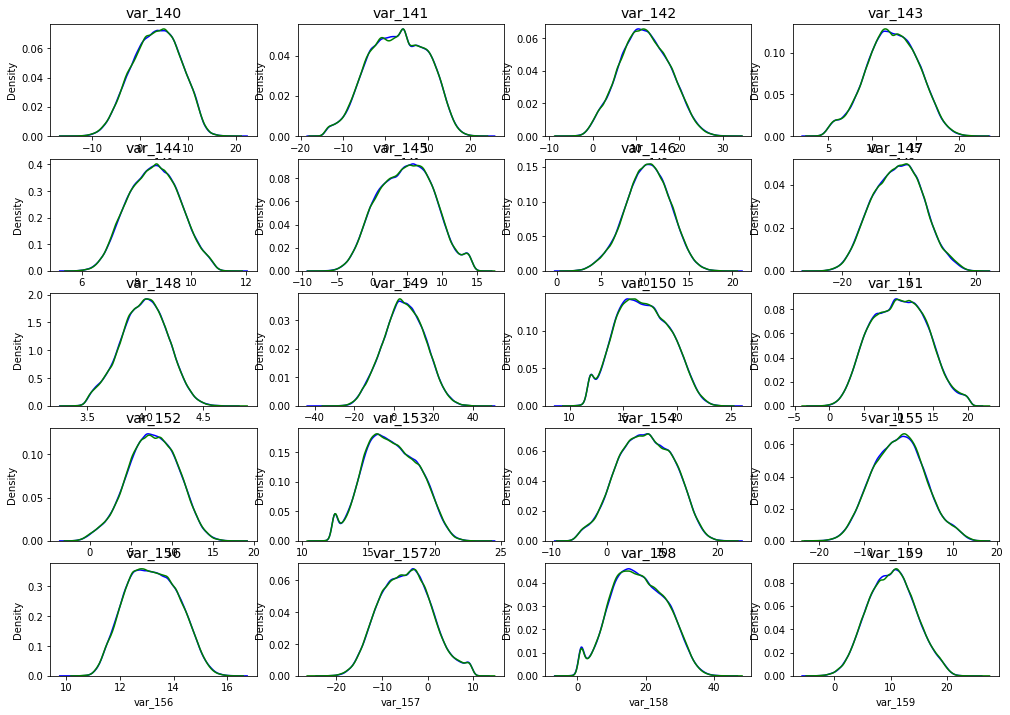

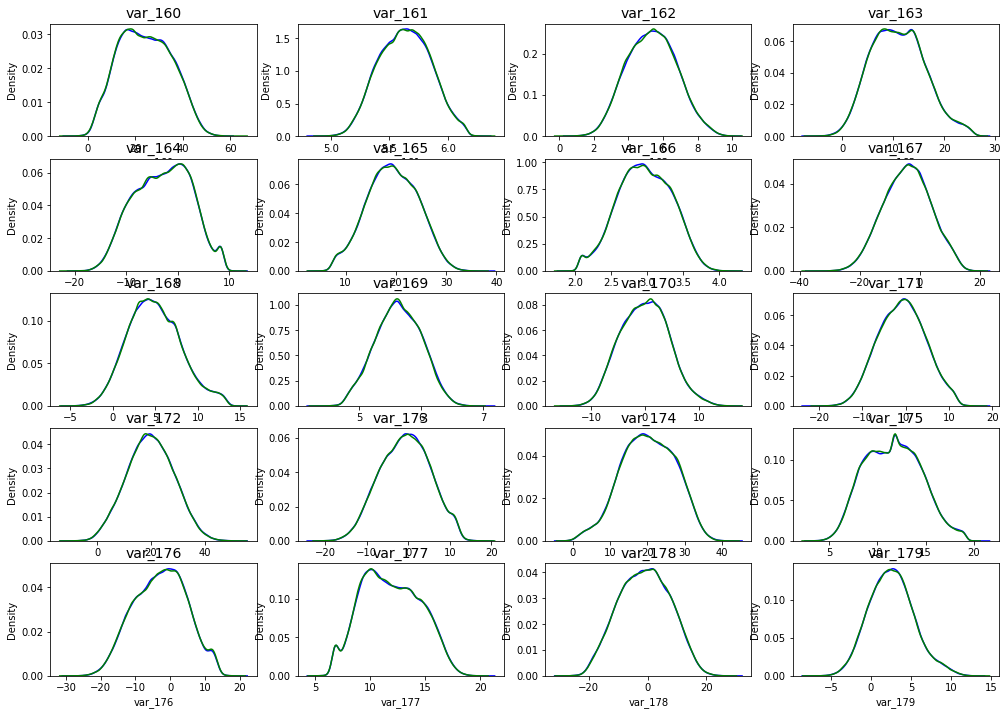

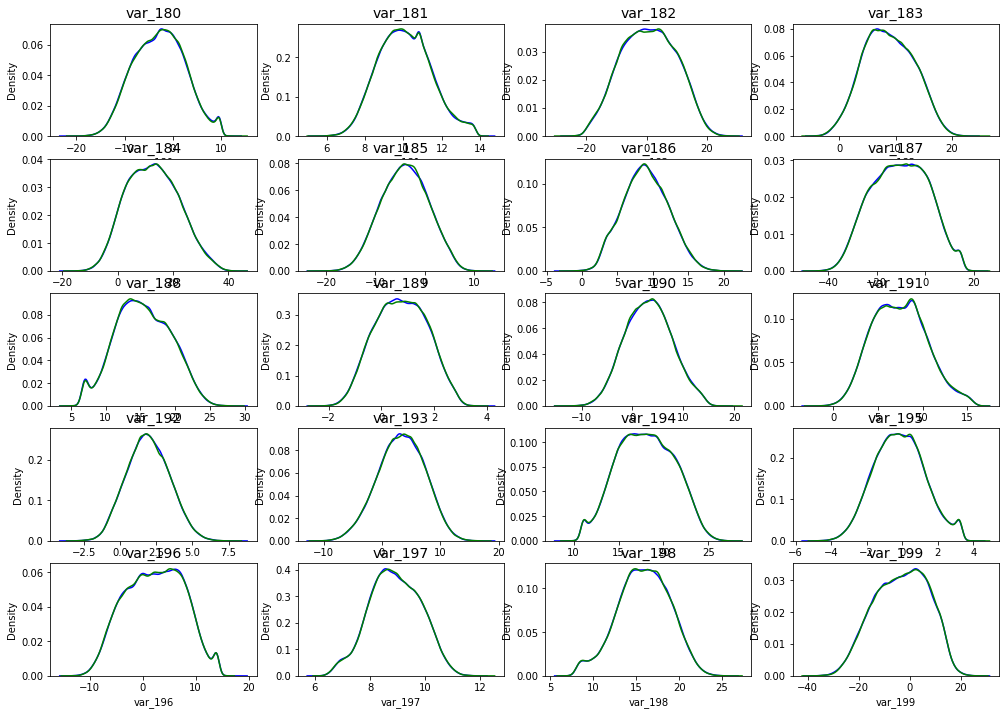

In [81]:
for i in range(10):
    group = continuous_feature_train[i * 20 : (i + 1) * 20]
    group_graf(group)

Выводы для обучающей и тестовой выборки (признаки): 
- визуально линии накладываются друг на друга точно, сильных отклонений не наблюдается
- видна асимметрия в признаках. Есть смысл более детально рассмотреть kurtosis, skewness

In [83]:
def feat_target_graf(group): 
    fig, axes = plt.subplots(5, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        target_0 = df_train.loc[df_train['target'] == 0, feature]
        target_1 = df_train.loc[df_train['target'] == 1, feature] 
                    
        sns.kdeplot(target_0, ax=axes[num//4, num%4], color="blue", label="0")
        sns.kdeplot(target_1, ax=axes[num//4, num%4], color="red", label="1")
            
        axes[num//4, num%4].set_title(feature, fontsize=14)

In [85]:
#названия признаков тестовой и обучающей выборки одинаковы

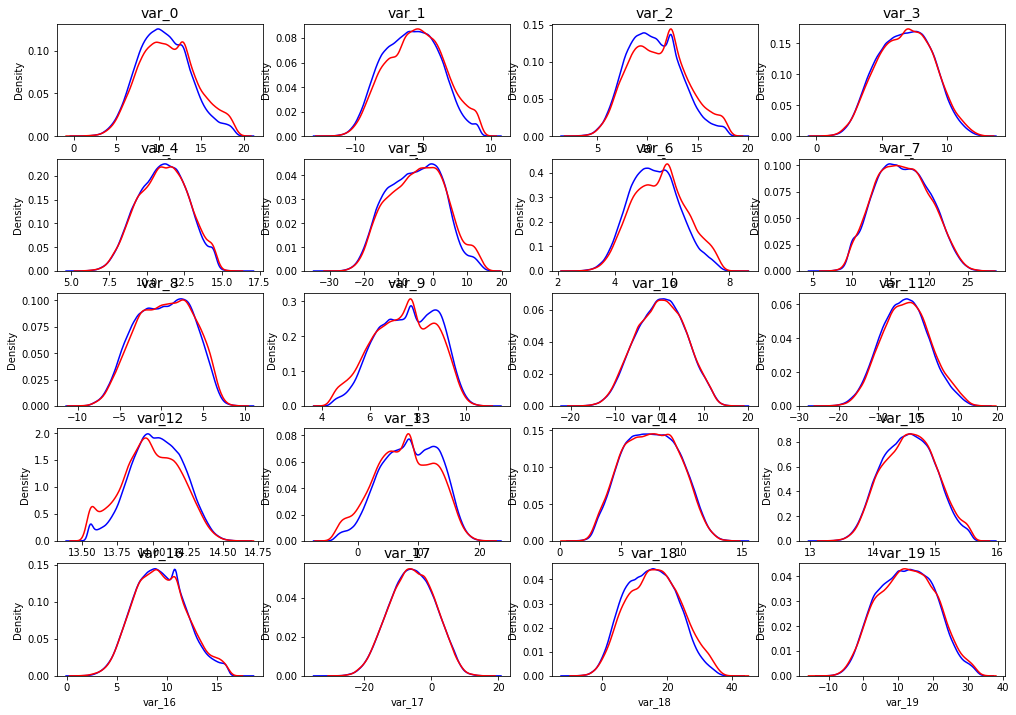

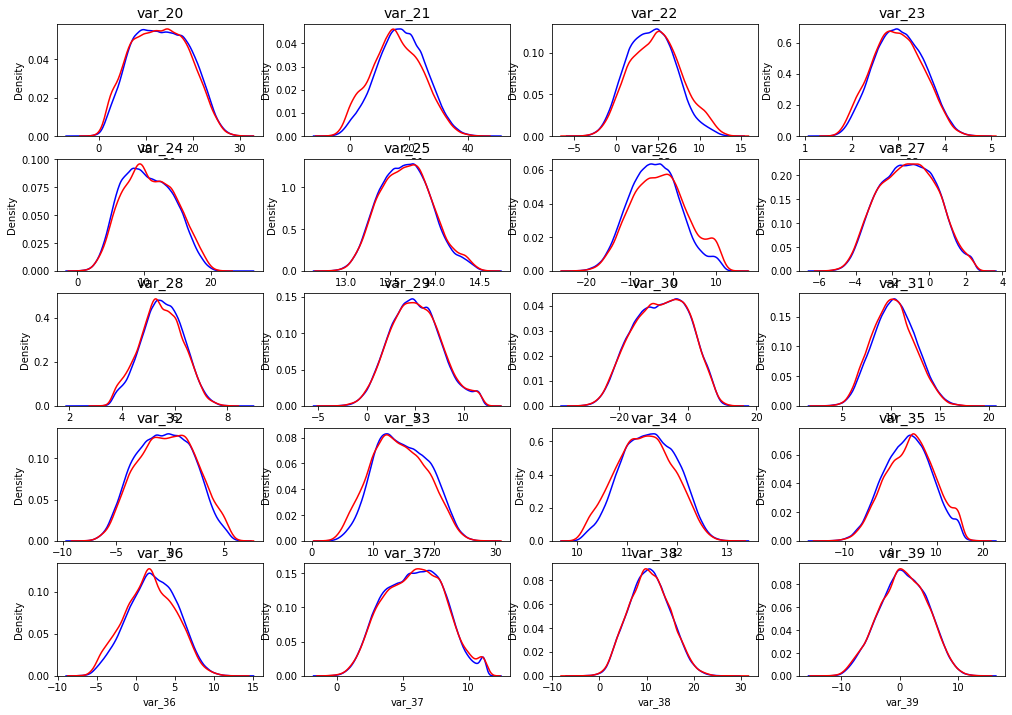

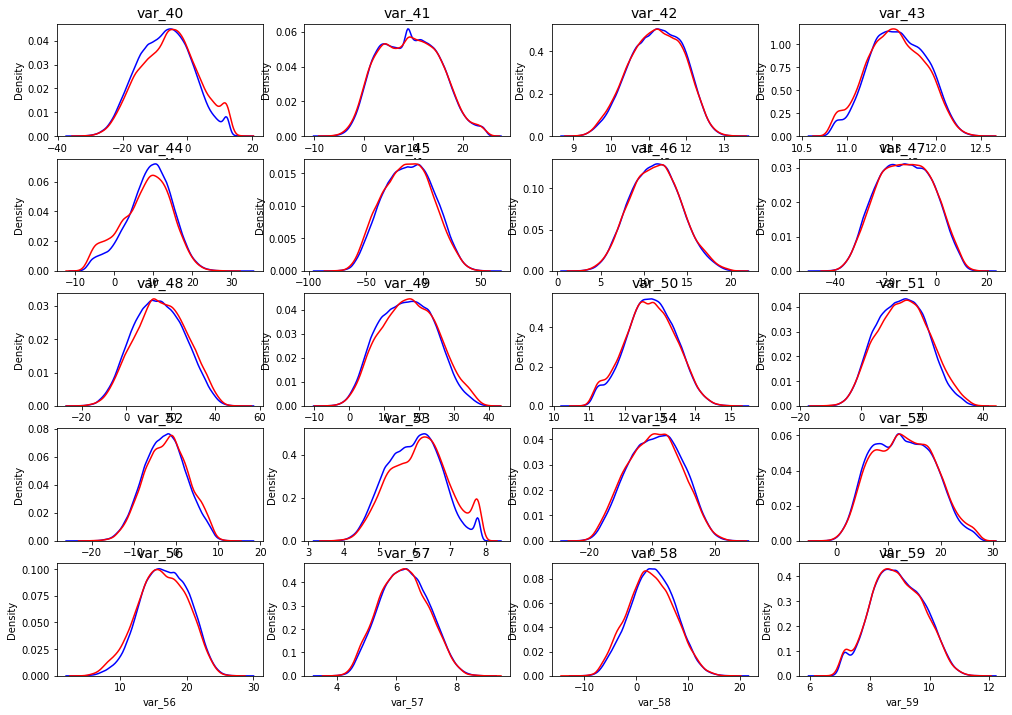

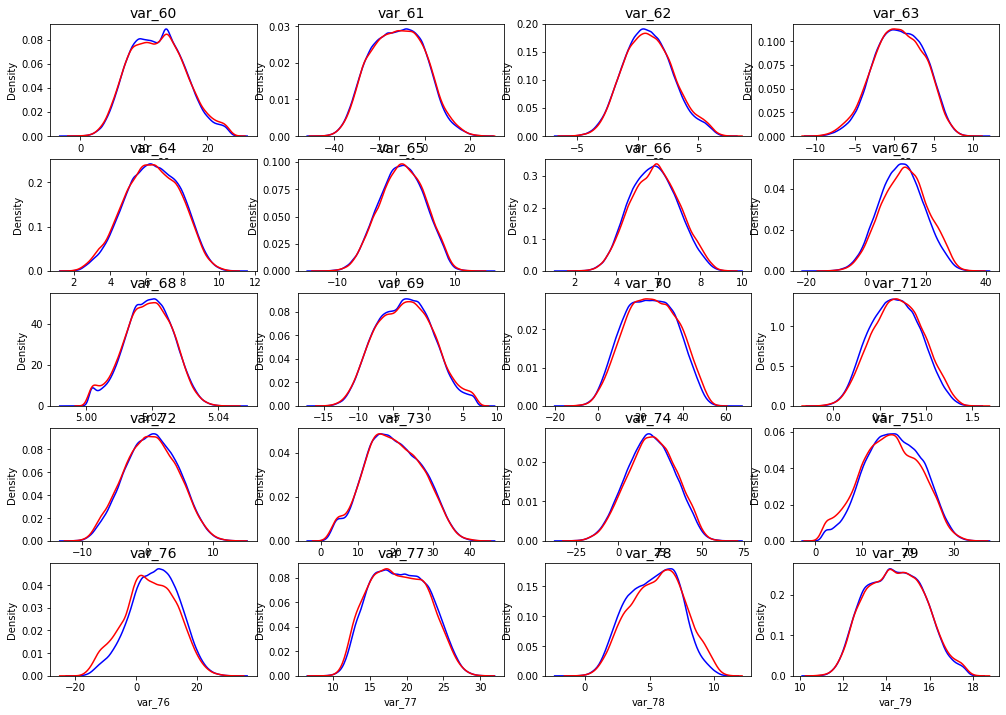

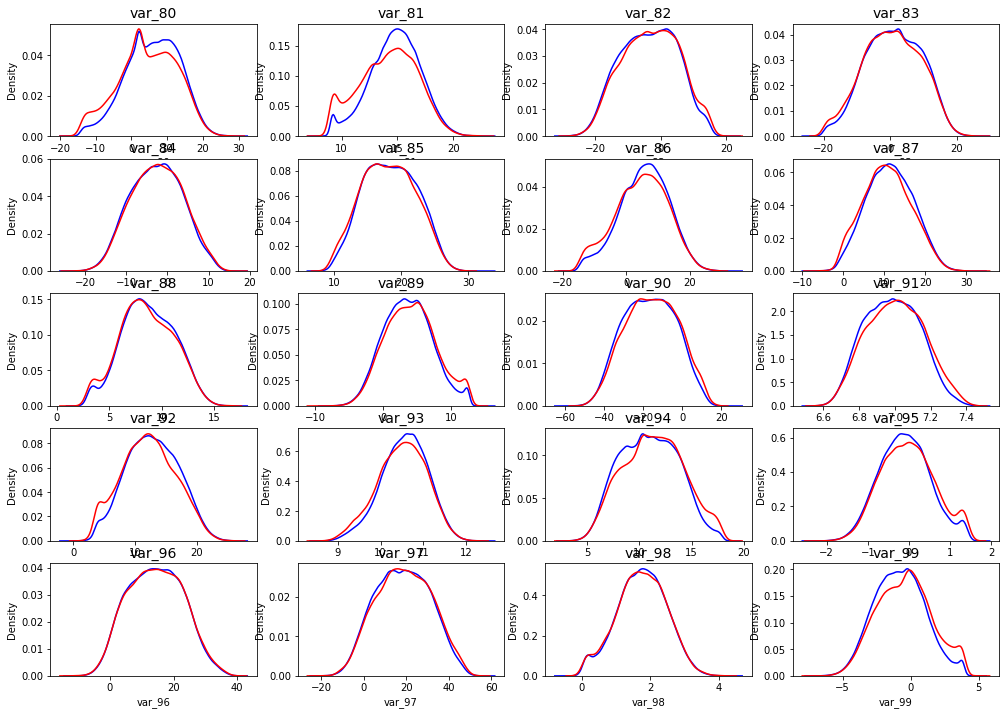

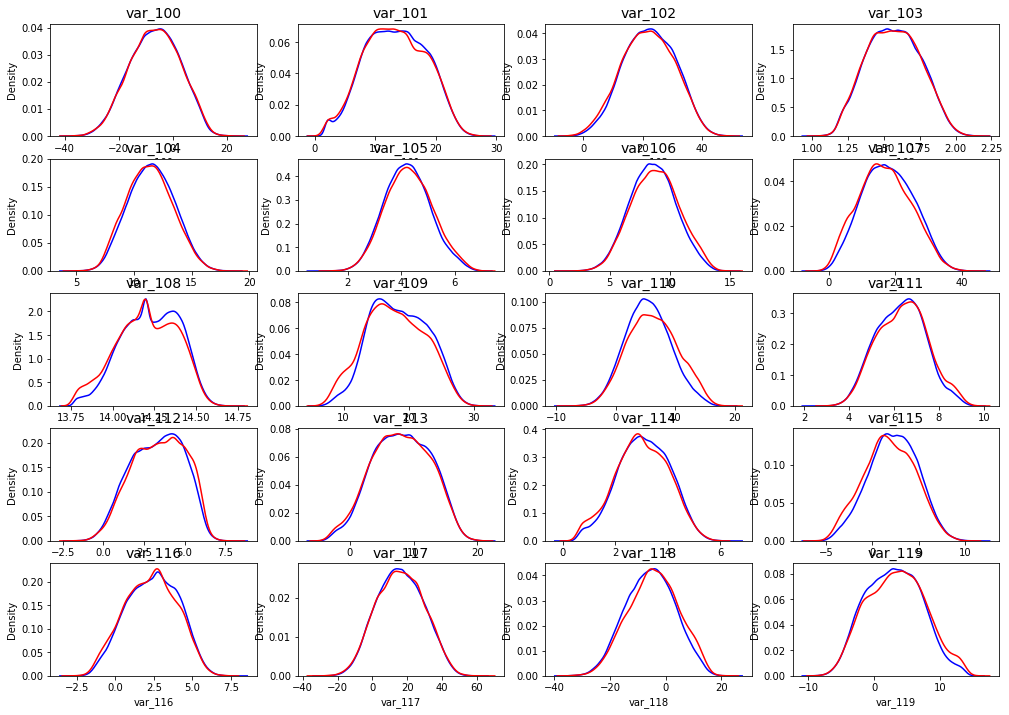

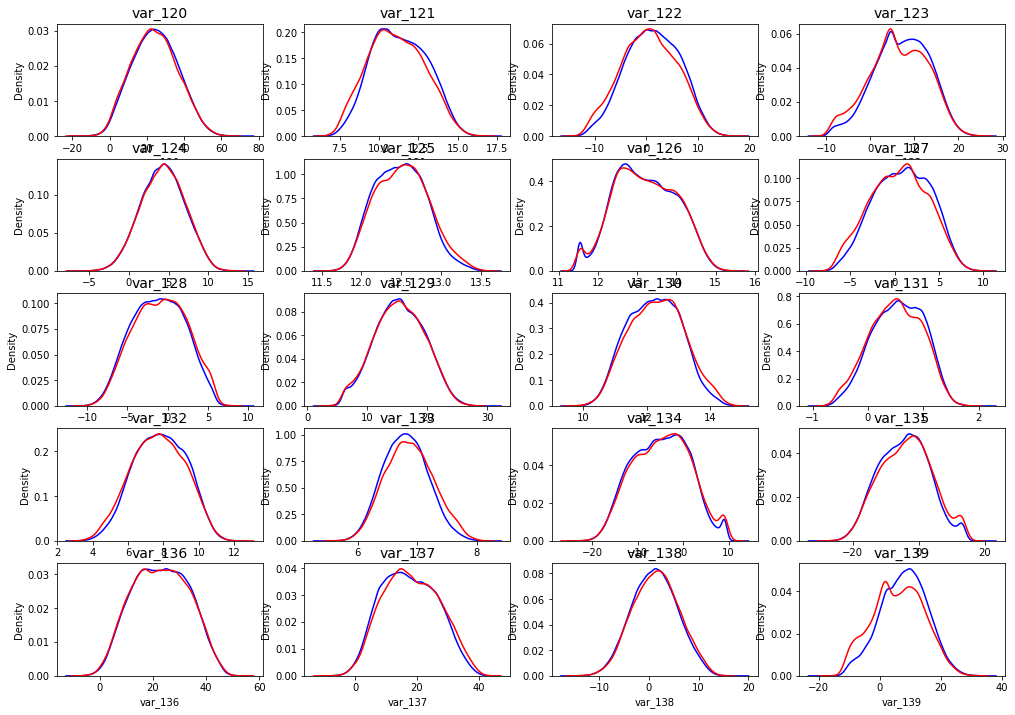

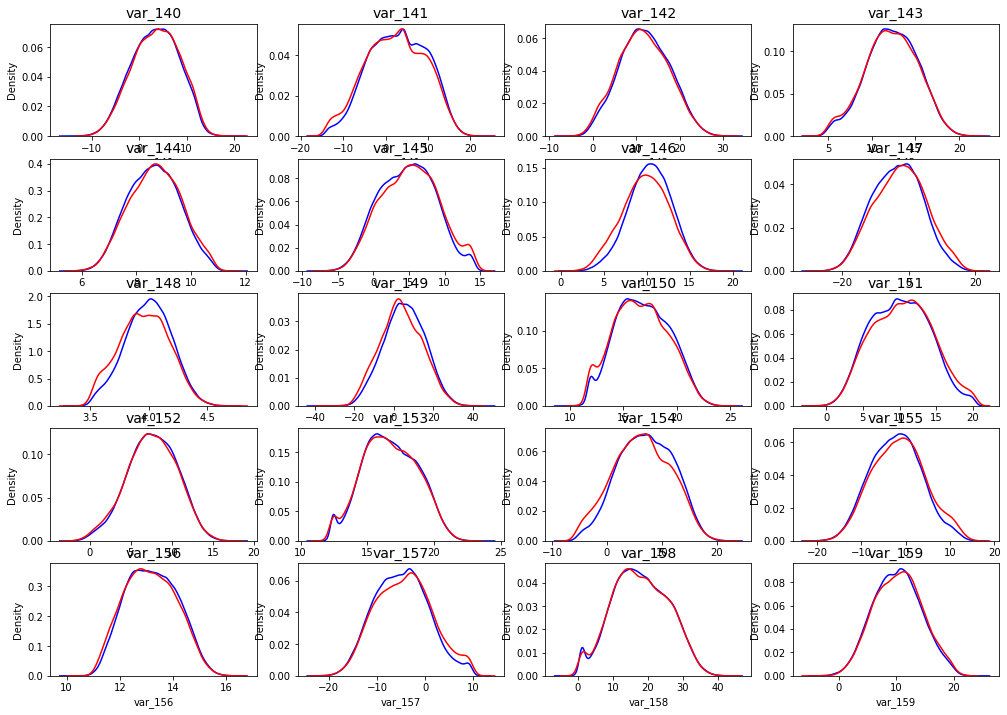

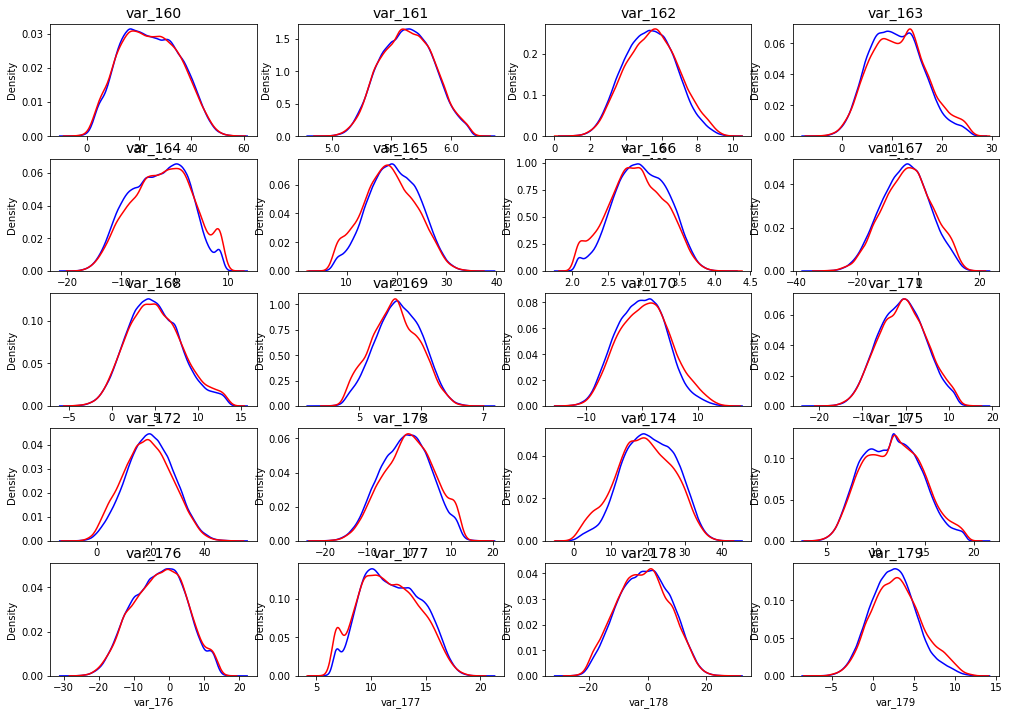

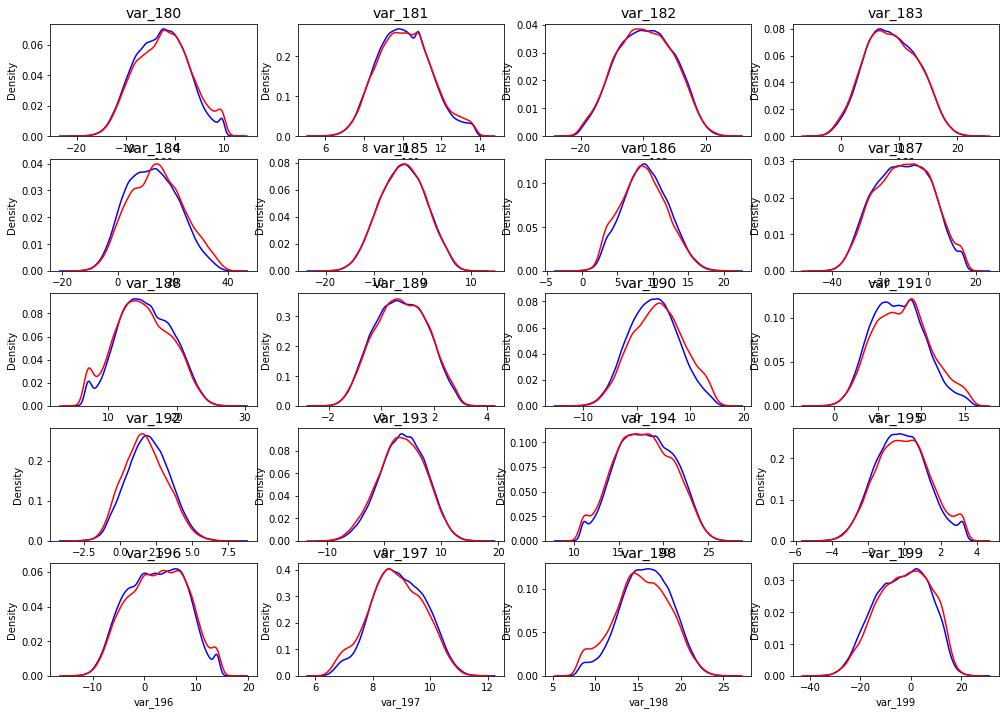

In [84]:
for i in range(10):
    group = continuous_feature_train[i * 20 : (i + 1) * 20]
    feat_target_graf(group)

In [86]:
#Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) 
#в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки,
#сделать выводы;

In [87]:
train_stat_0 = df_train[df_train['target'] == 0].drop(['ID_code', 'target'], axis=1).describe()
train_stat_1 = df_train[df_train['target'] == 1].drop(['ID_code', 'target'], axis=1).describe()
stat_test = df_test.drop(['ID_code'], axis=1).describe()

In [88]:
train_stat_0.head()

var_0          var_1          var_2          var_3  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       10.626681      -1.695770      10.665876       6.788979   
std         3.008564       4.024813       2.612961       2.040082   
min         0.408400     -15.043400       2.117100      -0.040200   
25%         8.429500      -4.790775       8.698025       5.247625   

               var_4          var_5          var_6          var_7  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       11.072412      -5.146736       5.389620      16.549306   
std         1.620103       7.827522       0.857983       3.417700   
min         5.074800     -32.562600       2.347300       5.349700   
25%         9.880600     -11.260950       4.756425      13.950125   

               var_8          var_9  ...        var_190        var_191  \
count  179902.000000  179902.000000  ...  179902.000000  179902.000000   
mean        0.262347       7.584907  ...       3.149130       7.390800   
std         3.331105       1.228839  ...       4.522568       2.997847   
min       -10.505500       3.970500  ...     -14.093300      -2.691700   
25%        -2.342575       6.637500  ...      -0.111850       5.130825   

             var_192        var_193        var_194        var_195  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean        1.949017       3.355403      18.017716      -0.155601   
std         1.476456       3.982819       3.127715       1.422275   
min        -3.814500     -10.845500       8.694400      -5.261000   
25%         0.915300       0.612400      15.656700      -1.178700   

             var_196        var_197        var_198        var_199  
count  179902.000000  179902.000000  179902.000000  179902.000000  
mean        2.260297       8.919032      15.924058      -3.415273  
std         5.441118       0.917467       2.978539      10.434525  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.987375       8.262100      13.896000     -11.312025  

[5 rows x 200 columns]

In [89]:
def stat_graf(stat_index):
    
    plt.figure(figsize=(16, 4))
    plt.title(stat_index)
    
    plt.plot(train_stat_0.loc[stat_index], alpha=0.5, label='1')
    plt.plot(train_stat_1.loc[stat_index], alpha=0.5, label='0')
    plt.plot(stat_test.loc[stat_index], alpha=0.5, label='test')
    
    plt.grid(axis='y')
    plt.legend()

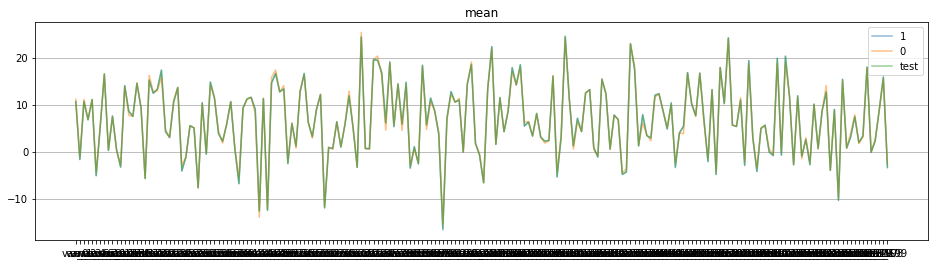

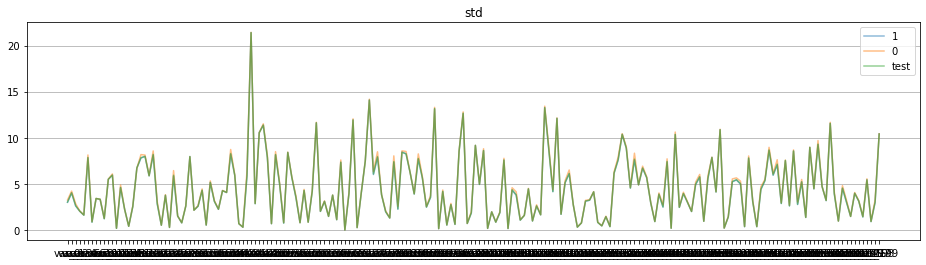

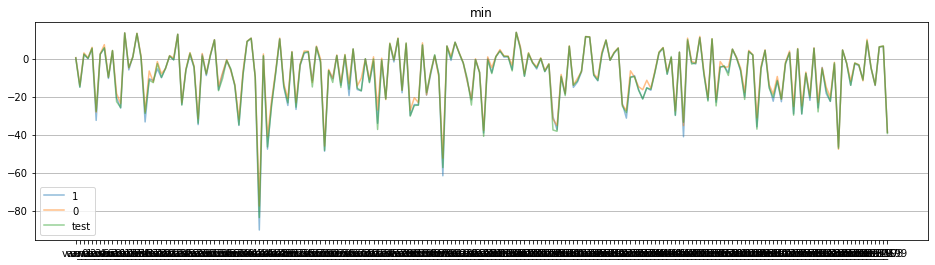

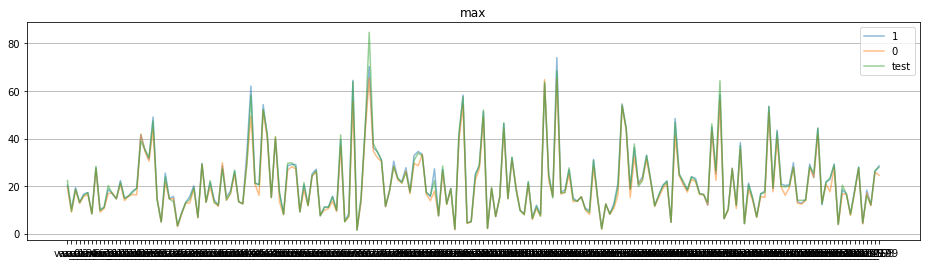

In [90]:
stat_graf('mean')
stat_graf('std')
stat_graf('min')
stat_graf('max')

Выводы: 
- распределения std, mean практически точно накладываются друг на друга
- распределения min-max заметно отличаются (особенно max), это подтверждает наши предыдующие рассуждения
  о выбросах и асимметрии
- на некоторых областях label 1 отстает (или наоборот, слишком увеличивается) от label 0 
- min/max значения: от -80 до +80 по всем признакам 

In [91]:
#как и в прошлом задании можно попробовать разбить данные в диапазоне 50-100-150-200 признаков, чтобы 
# более детально все рассмотреть. 

In [92]:
#Задание 5: Построить распределение коэффициентов корреляции между признаками.
#Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует,
#если коэффициент корреляции < 0.2)?

In [94]:
correlation = numerical_features_train.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

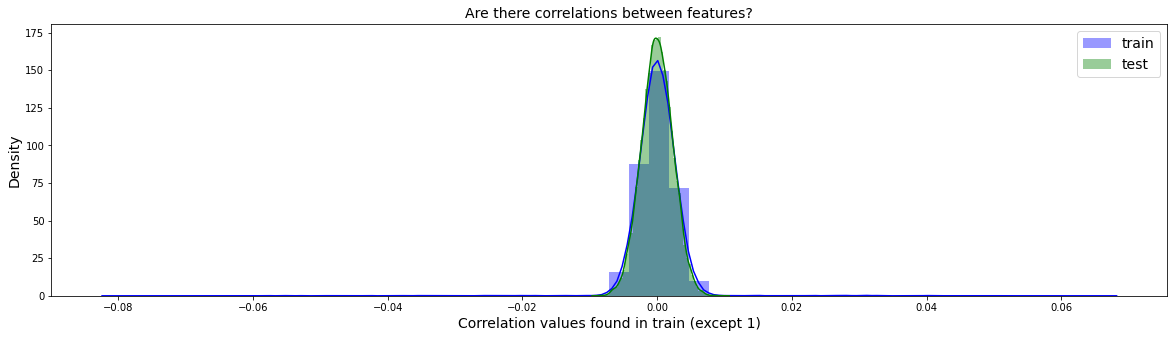

In [95]:
train_correlations = numerical_features_train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features_train.columns.tolist()
columns.remove("target")

test_correlations = df_test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

In [96]:
train_correlations[train_correlations >= 0.2]

array([], dtype=float64)

In [97]:
test_correlations[test_correlations >= 0.2]

array([], dtype=float64)

Вывод: корреляций между фичами, выше 0.2, в тестовой и обучающей выборке нет.

In [98]:
#Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [99]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)

Wall time: 15 ms


In [100]:
forest.fit(df_train[continuous_feature_train], df_train['target'])

RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'Top 10 features to start work with')

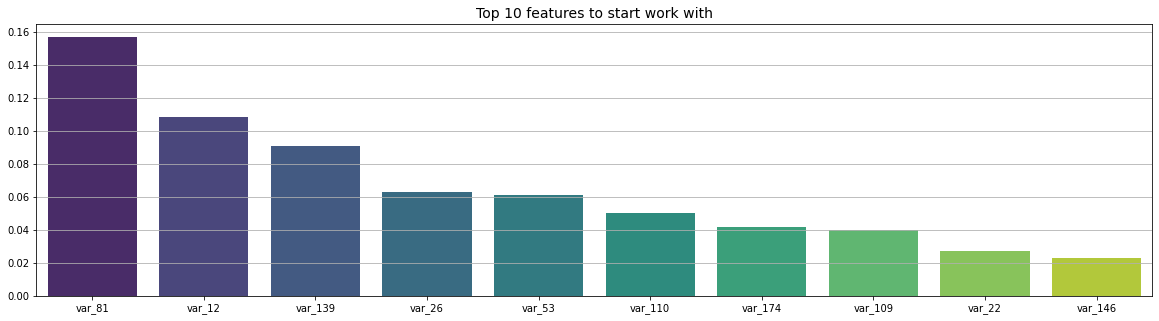

In [103]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]

plt.figure(figsize=(20, 5))
sns.barplot(x=df_train[continuous_feature_train].columns[idx], y=importances[idx], palette='viridis')
plt.grid(axis='y')
plt.title("Top 10 features to start work with", size=14)

## Adversarial validation and Kolmogorov-Smirnov test

var_174, распределение не идентично: pvalue=0.042
var_146, распределение не идентично: pvalue=0.029


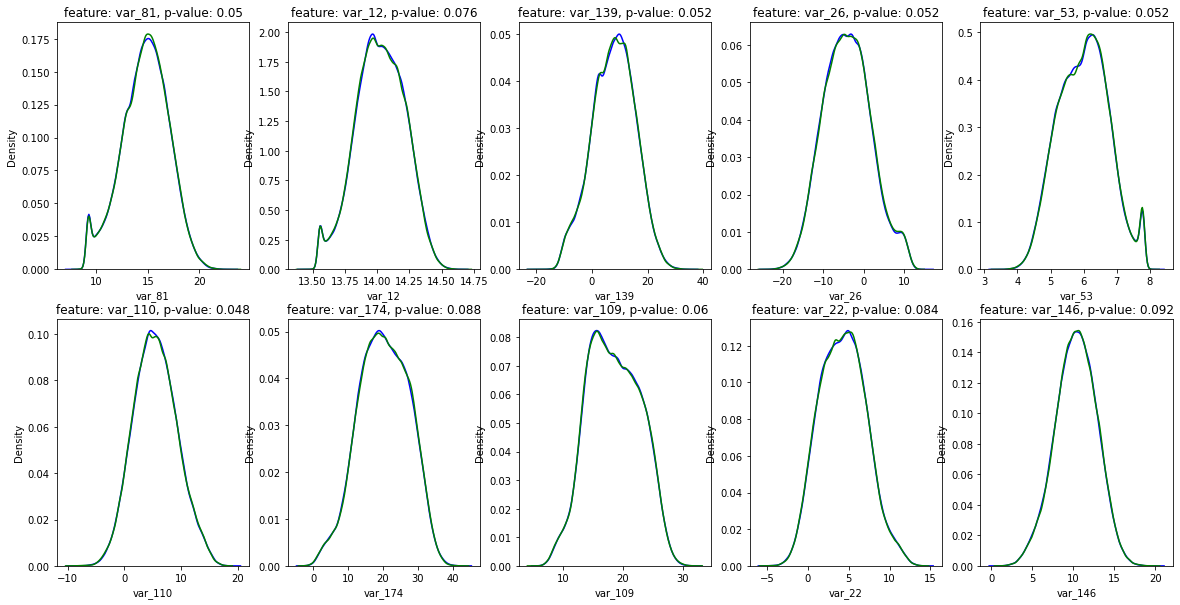

In [110]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(df_train[continuous_feature_train].columns[idx]):
    statistic, pvalue = ks_2samp(
        df_train[feature].sample(500), df_test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(df_train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(df_test[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"feature: {feature}, p-value: {round(statistic, 3)}")
    )
    if pvalue < 0.05:               
        print(f'{feature}, распределение не идентично: pvalue={round(pvalue,3)}')

Выборки почти идентичны. Различимые результаты pvalue только для двух переменных (174, 146)

In [113]:
numerical_features_train = numerical_features_train.drop(["target"], axis=1).columns.tolist()

In [114]:
X_adv = pd.concat([
    df_train[numerical_features_train], df_test[numerical_features_train]
])
y_adv = np.hstack(
    (np.ones(df_train.shape[0]), np.zeros(df_test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [116]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)
print(f"CV-score: {round(np.mean(cv), 4)}")

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-score: 0.5116
Wall time: 17min 21s


In [117]:
model.fit(X_adv, y_adv)

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=2, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

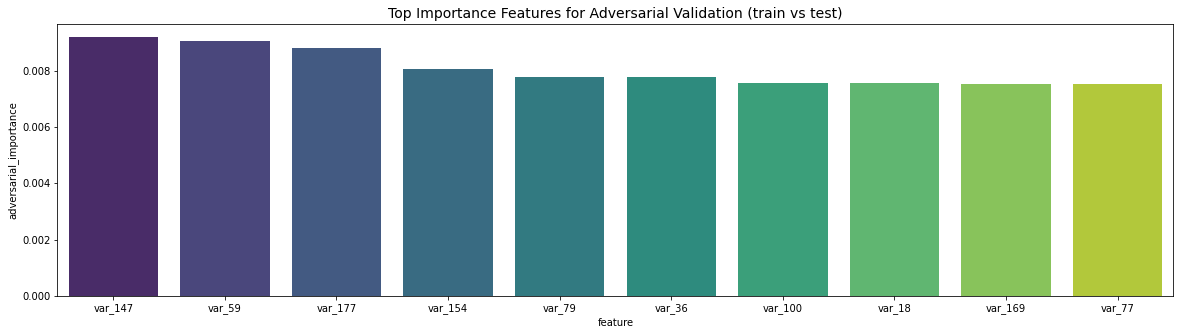

In [118]:
importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)